Trial 10 Complete [00h 03m 31s]
val_accuracy: 0.47749999165534973

Best val_accuracy So Far: 0.7641666531562805
Total elapsed time: 00h 26m 07s
38/38 [==============================] - 1s 9ms/step - loss: 0.5325 - accuracy: 0.7642
Test loss: 0.5325
Test accuracy: 0.7642
38/38 [==============================] - 1s 5ms/step
Test AUC: 0.8428
Epoch 1/200
338/338 [==============================] - 16s 20ms/step - loss: 0.3955 - accuracy: 0.8327 - val_loss: 0.5676 - val_accuracy: 0.7533
Epoch 2/200
338/338 [==============================] - 6s 18ms/step - loss: 0.3933 - accuracy: 0.8340 - val_loss: 0.6545 - val_accuracy: 0.7058
Epoch 3/200
338/338 [==============================] - 7s 20ms/step - loss: 0.3850 - accuracy: 0.8385 - val_loss: 0.6035 - val_accuracy: 0.7375
Epoch 4/200
338/338 [==============================] - 6s 18ms/step - loss: 0.3734 - accuracy: 0.8483 - val_loss: 0.7008 - val_accuracy: 0.7142
Epoch 5/200
338/338 [==============================] - 7s 20ms/step - loss: 0.3699

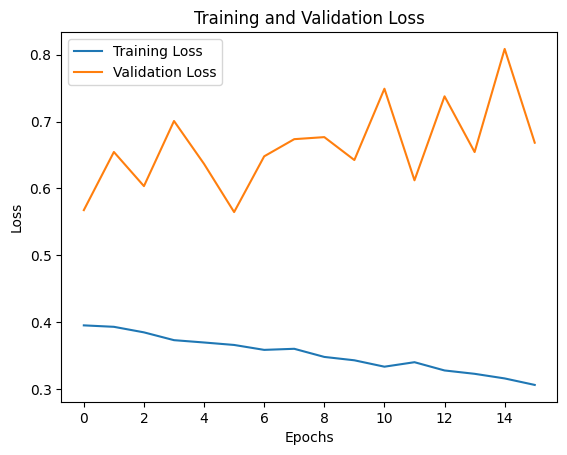

Best Hyperparameters:
{'filters': 184, 'dropout_rate': 0.4, 'learning_rate': 0.0001}


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import keras_tuner as kt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

# Load data from the text file (replace 'K562_merged.txt' with the actual file path)
data = pd.read_csv('K562_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.1, random_state=42)

# Function to create the BPNet model
def residual_block(x, dilation_rate):
    shortcut = Conv1D(filters=64, kernel_size=1, padding='same')(x) # Adjust shortcut to match the filter size
    x = Conv1D(filters=64, kernel_size=3, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(0.01))(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same', dilation_rate=dilation_rate, kernel_regularizer=l2(0.01))(x)
    x = Add()([x, shortcut]) # Now the shapes should match
    x = Activation('relu')(x)
    return x
def create_bpnet_model(hp):
    inputs = Input(shape=(sequence_length, 4))

    # Initial convolutional layer
    x = Conv1D(filters=hp.Int('filters', min_value=64, max_value=256, step=4),
               kernel_size=25,
               padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

    # Nine dilated convolutional layers with residual skip connections and exponential dilation
    for i in range(9):
        x = residual_block(x, dilation_rate=2**i)

    # Flatten and Dense layer for binary classification
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001]))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = kt.RandomSearch(create_bpnet_model, objective='val_accuracy', max_trials=10, directory='my_dir', project_name='my_project', overwrite=True)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Predict probabilities for ROC curve
y_pred_prob = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Test AUC: {test_auc:.4f}")

# Plot training loss and validation loss
history = best_model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(best_hyperparameters.values)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 197, 32)           544       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1568)              0         
                                                                 
 dense_3 (Dense)             (None, 16)                25104     
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 25665 (100.25 KB)
Trainable params: 25665 (100.25 KB)
Non-trainable params: 0 (0.00 Byte)
________________

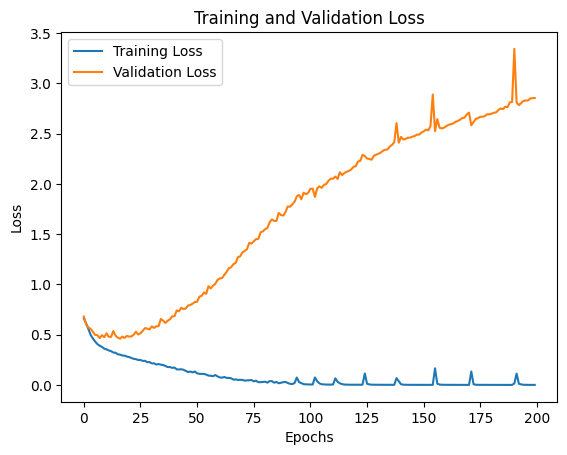

Model saved successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Load data from the text file (replace 'K562_merged.txt' with the actual file path)
data = pd.read_csv('K562_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.1, random_state=42)

# Create the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(200, 4))) # Correct input shape
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Binary classification requires a single output node with sigmoid activation

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Use binary_crossentropy for binary classification

# ... (rest of your code remains the same)

# Summary of the model architecture
model.summary()

# Train the model on your training data (X_train, y_train)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained model
model.save('my_cnn_model.h5')
print("Model saved successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 197, 32)           544       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 1568)              0         
                                                                 
 dense_7 (Dense)             (None, 16)                25104     
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 25665 (100.25 KB)
Trainable params: 25665 (100.25 KB)
Non-trainable params: 0 (0.00 Byte)
________________

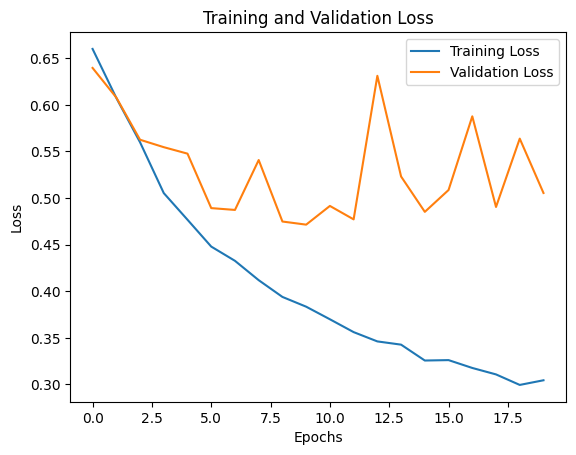

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Load data from the text file (replace 'K562_merged.txt' with the actual file path)
data = pd.read_csv('K562_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.1, random_state=42)

# Create the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(200, 4))) # Correct input shape
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Binary classification requires a single output node with sigmoid activation

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Use binary_crossentropy for binary classification

# ... (rest of your code remains the same)

# Summary of the model architecture
model.summary()

# Assuming you have already trained the model (replace this with your actual training data)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 197, 32)           544       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 1568)              0         
                                                                 
 dense_13 (Dense)            (None, 16)                25104     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                      

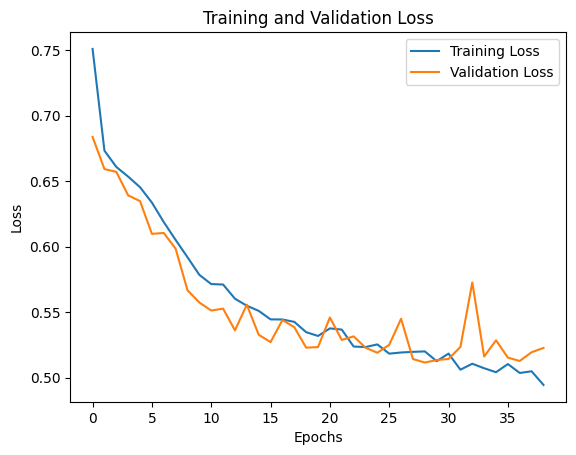

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Load data from the text file (replace 'K562_merged.txt' with the actual file path)
data = pd.read_csv('K562_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.1, random_state=42)

# ... (previous code remains the same)

# Create the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(sequence_length, 4))) # Use sequence_length for correct input shape
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dropout(0.5))  # Add dropout layer
model.add(Dense(1, activation='sigmoid')) # Binary classification requires a single output node with sigmoid activation

# ... (rest of the code remains the same)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Use binary_crossentropy for binary classification

# ... (rest of your code remains the same)

# Summary of the model architecture
model.summary()

# Assuming you have already trained the model (replace this with your actual training data)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_39 (Conv1D)          (None, 197, 32)           544       
                                                                 
 batch_normalization_4 (Bat  (None, 197, 32)           128       
 chNormalization)                                                
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 49, 32)            0         
 ng1D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 1568)              0         
                                                                 
 dense_23 (Dense)            (None, 64)                100416    
                                                                 
 dropout_8 (Dropout)         (None, 64)              

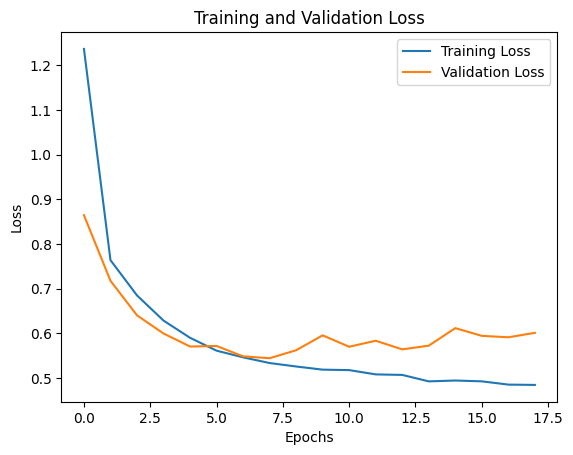

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Load data from the text file (replace 'K562_merged.txt' with the actual file path)
data = pd.read_csv('K562_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())  # Add batch normalization
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Change to a single output node for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Assuming you have already trained the model (replace this with your actual training data)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0] # Extract probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 197, 64)           1088      
                                                                 
 batch_normalization_3 (Bat  (None, 197, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 49, 64)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 128)           32896     
                                                                 
 batch_normalization_4 (Bat  (None, 46, 128)          

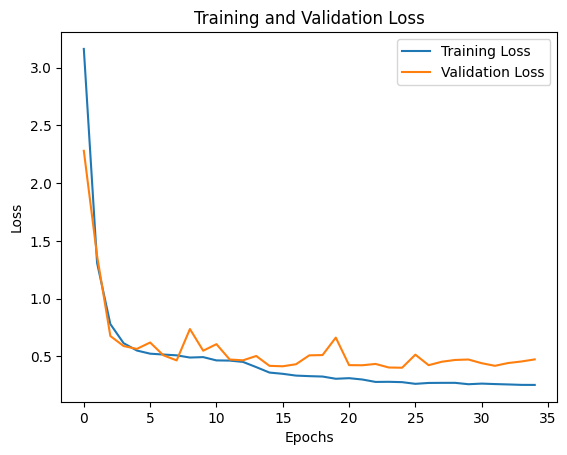

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load data from the text file (replace 'K562_merged.txt' with the actual file path)
data = pd.read_csv('K562_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=66)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 197, 64)           1088      
                                                                 
 batch_normalization_6 (Bat  (None, 197, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 49, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 46, 128)           32896     
                                                                 
 batch_normalization_7 (Bat  (None, 46, 128)          

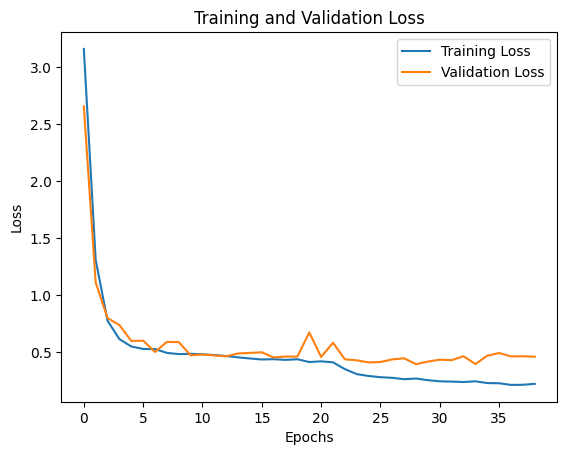

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load data from the text file (replace 'K562_merged.txt' with the actual file path)
data = pd.read_csv('K562_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=81)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 197, 64)           1088      
                                                                 
 batch_normalization (Batch  (None, 197, 64)           256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 128)           32896     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 128)           5

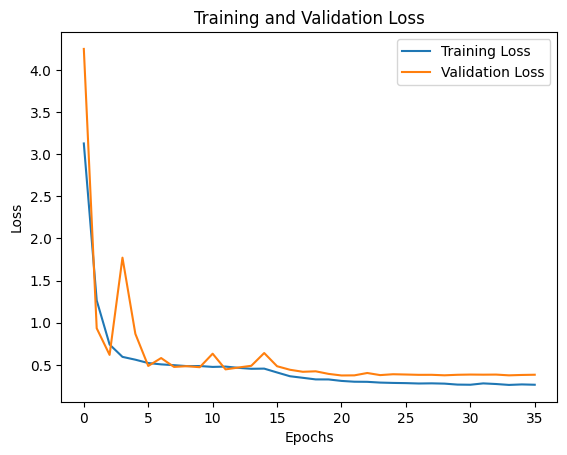

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load data from the text file (replace 'K562_merged.txt' with the actual file path)
data = pd.read_csv('K562_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=81)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Callbacks
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001)


# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

print("Number of epochs trained:", len(history.history['loss']))


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



TF1-CL1:train and validate:save model
   -CL2:test
TF2-CL1:test
   -CL2:test

do this for all cell lines. to get 4 models. prepare a color heat map matrix for visualization.

TF1:NANOG
TF2:POU5F1

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 197, 64)           1088      
                                                                 
 batch_normalization_18 (Ba  (None, 197, 64)           256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 49, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 49, 64)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 46, 128)           32896     
                                                                 
 batch_normalization_19 (Ba  (None, 46, 128)          

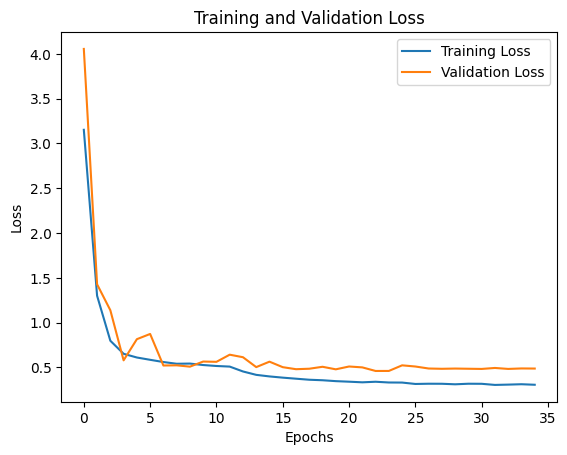

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load data from the text file (replace 'K562_merged.txt' with the actual file path)
data = pd.read_csv('H1_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=32)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Callbacks
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001)


# Train the model
history = model.fit(X_train, y_train, epochs=35, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

print("Number of epochs trained:", len(history.history['loss']))


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 196, 128)          2688      
                                                                 
 batch_normalization_9 (Bat  (None, 196, 128)          512       
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 49, 128)           0         
 g1D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 49, 128)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 45, 256)           164096    
                                                                 
 batch_normalization_10 (Ba  (None, 45, 256)          

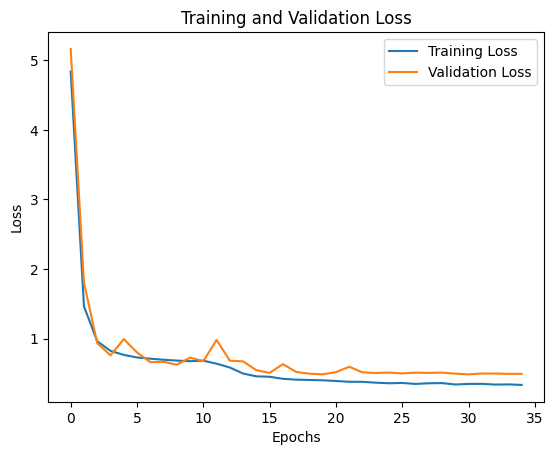

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load data from the text file (replace 'GM23338_merged.txt' with the actual file path)
data = pd.read_csv('GM23338_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=32)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.4))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Callbacks
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(X_train, y_train, epochs=35, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

print("Number of epochs trained:", len(history.history['loss']))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Epoch 1/40
300/300 [==============================] - 47s 151ms/step - loss: 4.4608 - accuracy: 0.6109 - val_loss: 6.0692 - val_accuracy: 0.5029 - lr: 0.0010
Epoch 2/40
300/300 [==============================] - 29s 98ms/step - loss: 1.2927 - accuracy: 0.7282 - val_loss: 1.3749 - val_accuracy: 0.5171 - lr: 0.0010
Epoch 3/40
300/300 [==============================] - 28s 94ms/step - loss: 0.8745 - accuracy: 0.7462 - val_loss: 0.8880 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 4/40
300/300 [==============================] - 27s 91ms/step - loss: 0.7837 - accuracy: 0.7702 - val_loss: 0.8878 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 5/40
300/300 [==============================] - 29s 98ms/step - loss: 0.7495 - accuracy: 0.7825 - val_loss: 0.8041 - val_accuracy: 0.7096 - lr: 0.0010
Epoch 6/40
300/300 [==============================] - 27s 91ms/step - loss: 0.7145 - accuracy: 0.7887 - val_loss: 0.9340 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 7/40
300/300 [==============================] - 27s

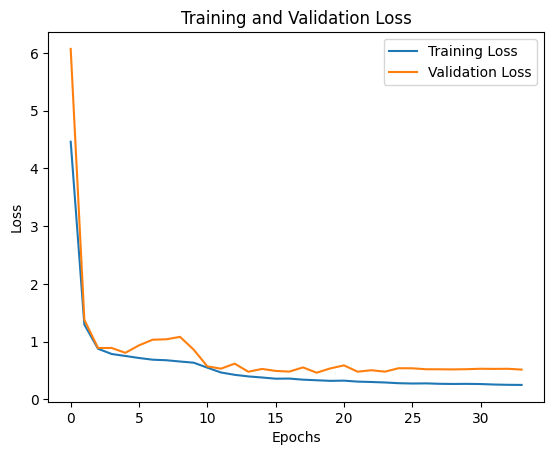

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf


# Load data from the text file (replace 'GM23338_merged.txt' with the actual file path)
data = pd.read_csv('GM23338_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    encoded_seq = np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])
    # Ensure all encoded sequences have the same length (200 in this case)
    if encoded_seq.shape[0] < 200:
        padding = np.zeros((200 - encoded_seq.shape[0], 4))
        encoded_seq = np.concatenate((encoded_seq, padding), axis=0)
    return encoded_seq

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=32)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with an initial learning rate
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adjust callbacks, consider adding a learning rate scheduler
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Train the model with adjusted parameters
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])
print("Number of epochs trained:", len(history.history['loss']))

# Evaluate and plot results as before
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Testt accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Epoch 1/40
300/300 [==============================] - 30s 92ms/step - loss: 4.3722 - accuracy: 0.6166 - val_loss: 7.9782 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 2/40
300/300 [==============================] - 28s 93ms/step - loss: 1.3020 - accuracy: 0.7179 - val_loss: 1.3485 - val_accuracy: 0.5346 - lr: 0.0010
Epoch 3/40
300/300 [==============================] - 28s 94ms/step - loss: 0.8769 - accuracy: 0.7520 - val_loss: 1.3420 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 4/40
300/300 [==============================] - 27s 92ms/step - loss: 0.7580 - accuracy: 0.7668 - val_loss: 0.6748 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 5/40
300/300 [==============================] - 29s 97ms/step - loss: 0.7014 - accuracy: 0.7756 - val_loss: 0.6548 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 6/40
300/300 [==============================] - 30s 99ms/step - loss: 0.6692 - accuracy: 0.7994 - val_loss: 0.8906 - val_accuracy: 0.6483 - lr: 0.0010
Epoch 7/40
300/300 [==============================] - 28s 

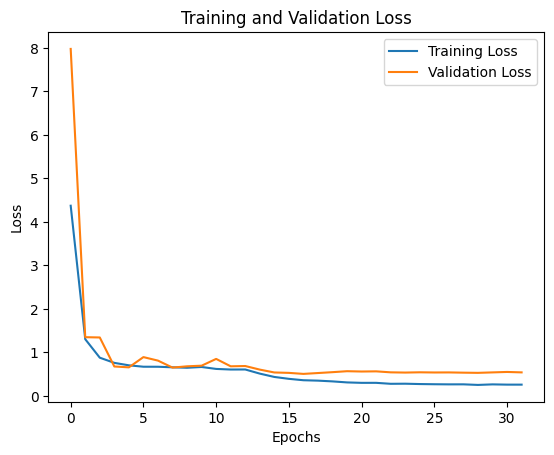

In [ ]:
#same code different random state
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf


# Load data from the text file (replace 'GM23338_merged.txt' with the actual file path)
data = pd.read_csv('GM23338_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    encoded_seq = np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])
    # Ensure all encoded sequences have the same length (200 in this case)
    if encoded_seq.shape[0] < 200:
        padding = np.zeros((200 - encoded_seq.shape[0], 4))
        encoded_seq = np.concatenate((encoded_seq, padding), axis=0)
    return encoded_seq

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=81)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with an initial learning rate
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adjust callbacks, consider adding a learning rate scheduler
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Train the model with adjusted parameters
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])
print("Number of epochs trained:", len(history.history['loss']))

# Evaluate and plot results as before
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Testt accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Epoch 1/40
300/300 [==============================] - 27s 85ms/step - loss: 7.6636 - accuracy: 0.5487 - val_loss: 2.7686 - val_accuracy: 0.5579 - lr: 0.0010
Epoch 2/40
300/300 [==============================] - 24s 79ms/step - loss: 2.0068 - accuracy: 0.6035 - val_loss: 1.6559 - val_accuracy: 0.6729 - lr: 0.0010
Epoch 3/40
300/300 [==============================] - 25s 83ms/step - loss: 1.6178 - accuracy: 0.6544 - val_loss: 1.3873 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 4/40
300/300 [==============================] - 26s 88ms/step - loss: 1.3495 - accuracy: 0.7070 - val_loss: 1.2486 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 5/40
300/300 [==============================] - 25s 84ms/step - loss: 1.1399 - accuracy: 0.7420 - val_loss: 1.0634 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 6/40
300/300 [==============================] - 25s 84ms/step - loss: 1.0131 - accuracy: 0.7574 - val_loss: 0.8877 - val_accuracy: 0.7987 - lr: 0.0010
Epoch 7/40
300/300 [==============================] - 24s 

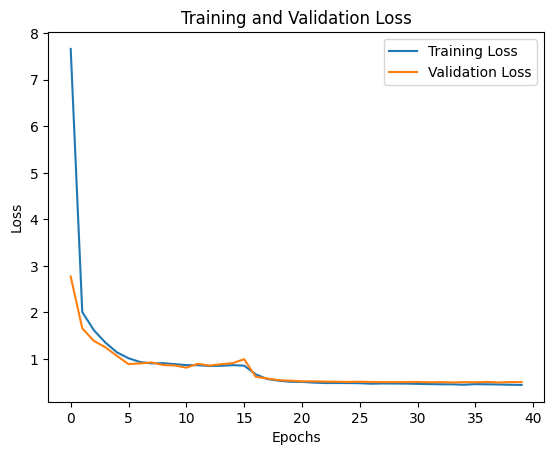

In [ ]:
#same code different random state
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf


# Load data from the text file (replace 'GM23338_merged.txt' with the actual file path)
data = pd.read_csv('GM23338_merged.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    encoded_seq = np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])
    # Ensure all encoded sequences have the same length (200 in this case)
    if encoded_seq.shape[0] < 200:
        padding = np.zeros((200 - encoded_seq.shape[0], 4))
        encoded_seq = np.concatenate((encoded_seq, padding), axis=0)
    return encoded_seq

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=81)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))  # Increased dropout rate
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l1=0.001)))  # Added L1 regularization
model.add(Dropout(0.5))  # Added dropout after dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model ...


# Compile the model with an initial learning rate
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adjust callbacks, consider adding a learning rate scheduler
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Train the model with adjusted parameters
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])
print("Number of epochs trained:", len(history.history['loss']))

# Evaluate and plot results as before
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Testt accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Save the entire model to a HDF5 file
model.save('GM23338.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
300/300 [==============================] - 6s 11ms/step - loss: 7.0058 - accuracy: 0.5979 - val_loss: 2.5077 - val_accuracy: 0.6237 - lr: 0.0010
Epoch 2/40
300/300 [==============================] - 3s 9ms/step - loss: 1.8677 - accuracy: 0.6567 - val_loss: 1.5521 - val_accuracy: 0.7354 - lr: 0.0010
Epoch 3/40
300/300 [==============================] - 3s 10ms/step - loss: 1.4669 - accuracy: 0.7092 - val_loss: 1.2558 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 4/40
300/300 [==============================] - 4s 13ms/step - loss: 1.2383 - accuracy: 0.7433 - val_loss: 1.1362 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 5/40
300/300 [==============================] - 3s 10ms/step - loss: 1.0751 - accuracy: 0.7650 - val_loss: 0.9749 - val_accuracy: 0.8004 - lr: 0.0010
Epoch 6/40
300/300 [==============================] - 2s 7ms/step - loss: 0.9611 - accuracy: 0.7800 - val_loss: 0.9236 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 7/40
300/300 [==============================] - 2s 6ms/step 

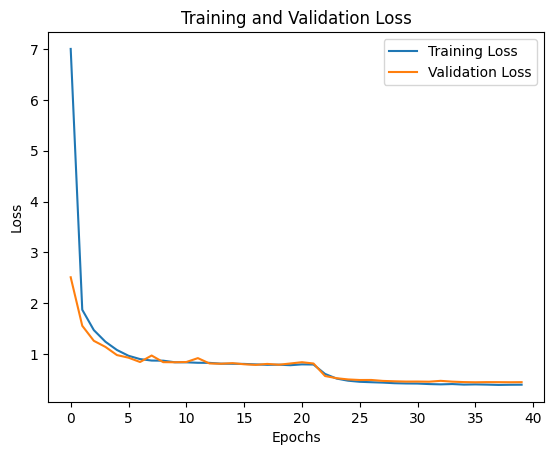

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#same code different random state
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf


# Load data from the text file (replace 'GM23338_merged.txt' with the actual file path)
data = pd.read_csv('H1_mergedNANOG.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    encoded_seq = np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])
    # Ensure all encoded sequences have the same length (200 in this case)
    if encoded_seq.shape[0] < 200:
        padding = np.zeros((200 - encoded_seq.shape[0], 4))
        encoded_seq = np.concatenate((encoded_seq, padding), axis=0)
    return encoded_seq

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=81)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))  # Increased dropout rate
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l1=0.001)))  # Added L1 regularization
model.add(Dropout(0.5))  # Added dropout after dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model ...


# Compile the model with an initial learning rate
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adjust callbacks, consider adding a learning rate scheduler
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Train the model with adjusted parameters
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])
print("Number of epochs trained:", len(history.history['loss']))

# Evaluate and plot results as before
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Testt accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the entire model to a HDF5 file
model.save('H1_NANOG.h5')


Epoch 1/40
300/300 [==============================] - 5s 8ms/step - loss: 7.0582 - accuracy: 0.5573 - val_loss: 2.3006 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 2/40
300/300 [==============================] - 2s 6ms/step - loss: 1.8327 - accuracy: 0.6198 - val_loss: 1.6333 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 3/40
300/300 [==============================] - 2s 6ms/step - loss: 1.4730 - accuracy: 0.7134 - val_loss: 1.3688 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 4/40
300/300 [==============================] - 2s 6ms/step - loss: 1.2324 - accuracy: 0.7568 - val_loss: 1.0947 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 5/40
300/300 [==============================] - 2s 6ms/step - loss: 1.0772 - accuracy: 0.7734 - val_loss: 0.9831 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 6/40
300/300 [==============================] - 2s 6ms/step - loss: 0.9519 - accuracy: 0.8084 - val_loss: 0.8742 - val_accuracy: 0.8371 - lr: 0.0010
Epoch 7/40
300/300 [==============================] - 2s 8ms/step - lo

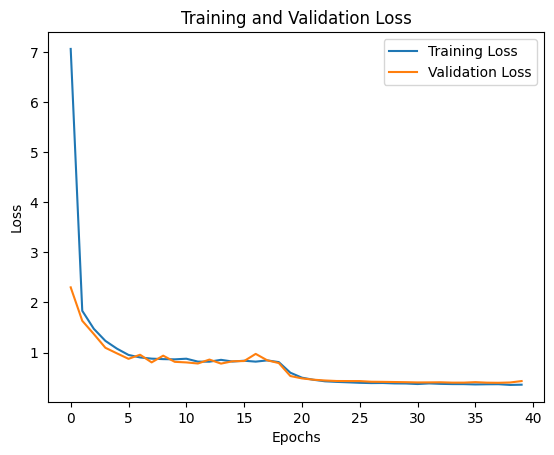

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#same code different random state
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf


# Load data from the text file (replace 'GM23338_merged.txt' with the actual file path)
data = pd.read_csv('GM23338_mergedPOU5F1.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    encoded_seq = np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])
    # Ensure all encoded sequences have the same length (200 in this case)
    if encoded_seq.shape[0] < 200:
        padding = np.zeros((200 - encoded_seq.shape[0], 4))
        encoded_seq = np.concatenate((encoded_seq, padding), axis=0)
    return encoded_seq

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=81)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))  # Increased dropout rate
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l1=0.001)))  # Added L1 regularization
model.add(Dropout(0.5))  # Added dropout after dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model ...


# Compile the model with an initial learning rate
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adjust callbacks, consider adding a learning rate scheduler
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Train the model with adjusted parameters
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])
print("Number of epochs trained:", len(history.history['loss']))

# Evaluate and plot results as before
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Testt accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the entire model to a HDF5 file
model.save('GM23338_mergedPOU5F1.h5')


Epoch 1/40
300/300 [==============================] - 4s 7ms/step - loss: 7.4371 - accuracy: 0.6187 - val_loss: 2.7660 - val_accuracy: 0.5583 - lr: 0.0010
Epoch 2/40
300/300 [==============================] - 2s 7ms/step - loss: 1.9026 - accuracy: 0.6433 - val_loss: 1.6239 - val_accuracy: 0.5825 - lr: 0.0010
Epoch 3/40
300/300 [==============================] - 2s 7ms/step - loss: 1.5550 - accuracy: 0.6725 - val_loss: 1.4165 - val_accuracy: 0.6683 - lr: 0.0010
Epoch 4/40
300/300 [==============================] - 2s 5ms/step - loss: 1.2556 - accuracy: 0.7076 - val_loss: 1.2038 - val_accuracy: 0.7254 - lr: 0.0010
Epoch 5/40
300/300 [==============================] - 2s 5ms/step - loss: 1.1260 - accuracy: 0.7334 - val_loss: 1.1325 - val_accuracy: 0.7350 - lr: 0.0010
Epoch 6/40
300/300 [==============================] - 2s 5ms/step - loss: 1.0286 - accuracy: 0.7459 - val_loss: 0.9917 - val_accuracy: 0.7717 - lr: 0.0010
Epoch 7/40
300/300 [==============================] - 2s 6ms/step - lo

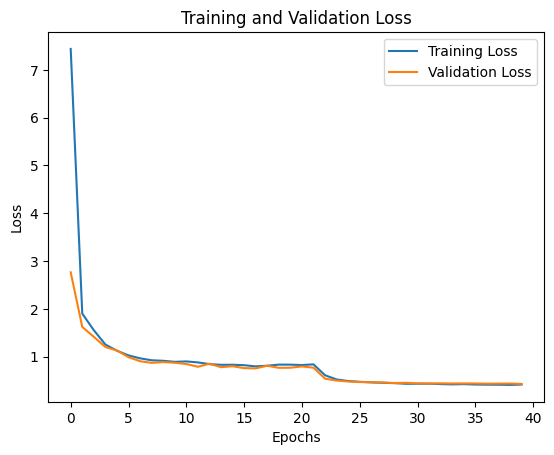

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#same code different random state
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf


# Load data from the text file (replace 'GM23338_merged.txt' with the actual file path)
data = pd.read_csv('H1_mergedPOU5F1.txt', sep='\t', header=None)
sequences = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

# One-hot encode sequences, handling 'N'
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    encoded_seq = np.array([mapping.get(base, [0, 0, 0, 0]) for base in sequence])
    # Ensure all encoded sequences have the same length (200 in this case)
    if encoded_seq.shape[0] < 200:
        padding = np.zeros((200 - encoded_seq.shape[0], 4))
        encoded_seq = np.concatenate((encoded_seq, padding), axis=0)
    return encoded_seq

one_hot_sequences = np.array([one_hot_encode(seq) for seq in sequences])

# Determine sequence length
sequence_length = one_hot_sequences.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences, labels, test_size=0.2, random_state=81)

# Create an improved CNN model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, 4)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))  # Increased dropout rate
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l1=0.001)))  # Added L1 regularization
model.add(Dropout(0.5))  # Added dropout after dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model ...


# Compile the model with an initial learning rate
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Adjust callbacks, consider adding a learning rate scheduler
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(patience=15, restore_best_weights=True)

# Train the model with adjusted parameters
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])
print("Number of epochs trained:", len(history.history['loss']))

# Evaluate and plot results as before
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Testt accuracy: {test_accuracy:.4f}")

# Calculate ROC AUC score
y_pred_prob = model.predict(X_test)[:, 0]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC score: {roc_auc:.4f}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the entire model to a HDF5 file
model.save('H1_mergedPOU5F1.h5')
